## Import Libraries

In [1]:
!pip install optuna xgboost lightgbm catboost imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 141.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.9/609.9 kB 50.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
import joblib

# Optuna
from optuna import load_study, create_study
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

# Sklearn Core
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score


# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

plt.style.use('ggplot')
SEED = 42

## Load and Prepare Data

In [4]:
def load_and_prep_data(filepath):
    """
    Loads data and creates the classification target based on exam_score.
    """
    df = pd.read_csv(filepath)
    df.drop('student_id', axis=1, inplace=True)

    # Drop duplicates if any
    df = df.drop_duplicates()

    # CLASSIFICATION LOGIC:
    # We map the continuous Exam_Score to 4 classes:
    def categorize_score(score):
        if score >= 85:
            return "Distinction"
        elif score >= 65:
            return "Good"
        elif score >= 50:
            return "Pass"
        else:
            return "Fail"

    # Create Target
    df['Performance_Category'] = df['exam_score'].apply(categorize_score)

    # Drop the original continuous target to prevent data leakage
    df = df.drop(columns=['exam_score'])

    return df

# Execution
df = load_and_prep_data('student_habits_dataset1.csv')
print(f"Data Loaded. Shape: {df.shape}")
print(f"Class Distribution:\n{df['Performance_Category'].value_counts(normalize=True)}")

Data Loaded. Shape: (1000, 16)
Class Distribution:
Performance_Category
Good           0.433
Pass           0.248
Distinction    0.188
Fail           0.131
Name: proportion, dtype: float64


In [ ]:
df

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,Independent_Effort,Performance_Category
0,23,Female,0.0,1.2,1.1,No,85.00000,8.0,Fair,6,Master,Average,8,Yes,0.000000,Pass
1,20,Female,6.9,2.8,2.3,No,97.30000,4.6,Good,6,High School,Average,8,No,6.430568,Distinction
2,21,Male,1.4,3.1,1.3,No,59.93405,8.0,Poor,1,High School,Poor,1,No,2.001886,Fail
3,23,Female,1.0,3.9,1.0,No,71.00000,9.2,Poor,4,Master,Good,1,Yes,1.234568,Fail
4,19,Female,5.0,4.4,0.5,No,90.90000,4.9,Fair,3,Master,Good,1,No,4.955401,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,21,Female,2.6,0.5,1.6,No,77.00000,7.5,Fair,2,High School,Good,6,Yes,2.988506,Good
996,17,Female,2.9,1.0,2.4,Yes,86.00000,6.8,Poor,1,High School,Average,6,Yes,3.020833,Good
997,20,Male,3.0,2.6,1.3,No,61.90000,6.5,Good,5,Bachelor,Good,9,Yes,4.172462,Pass
998,24,Male,5.4,4.1,1.1,Yes,100.00000,7.6,Fair,0,Bachelor,Average,1,No,4.909091,Good


## Exploratory Data Analysis

Generating plots for 15 features...


/tmp/ipython-input-583018749.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, order=category_order, palette='viridis')


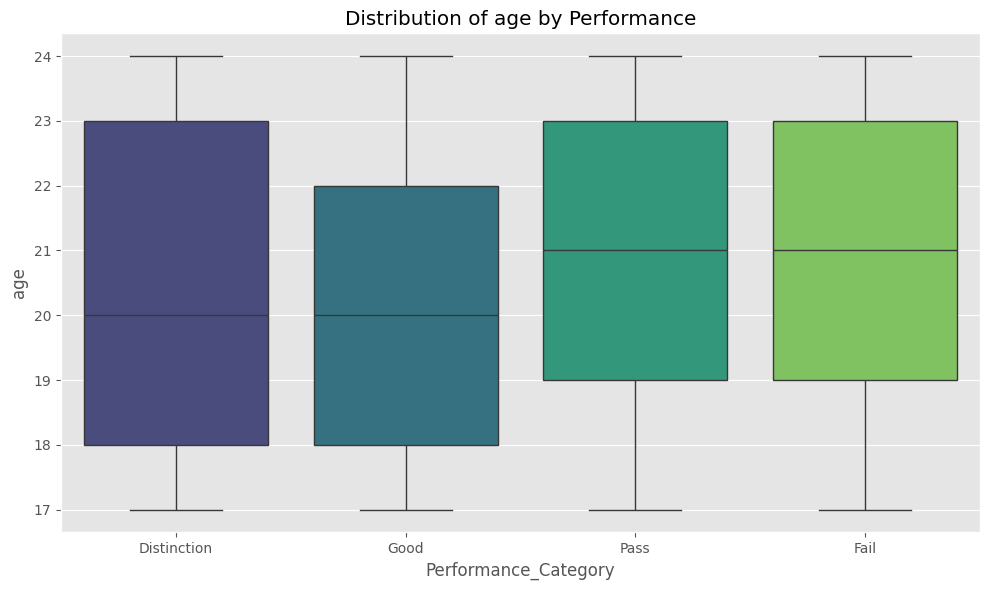

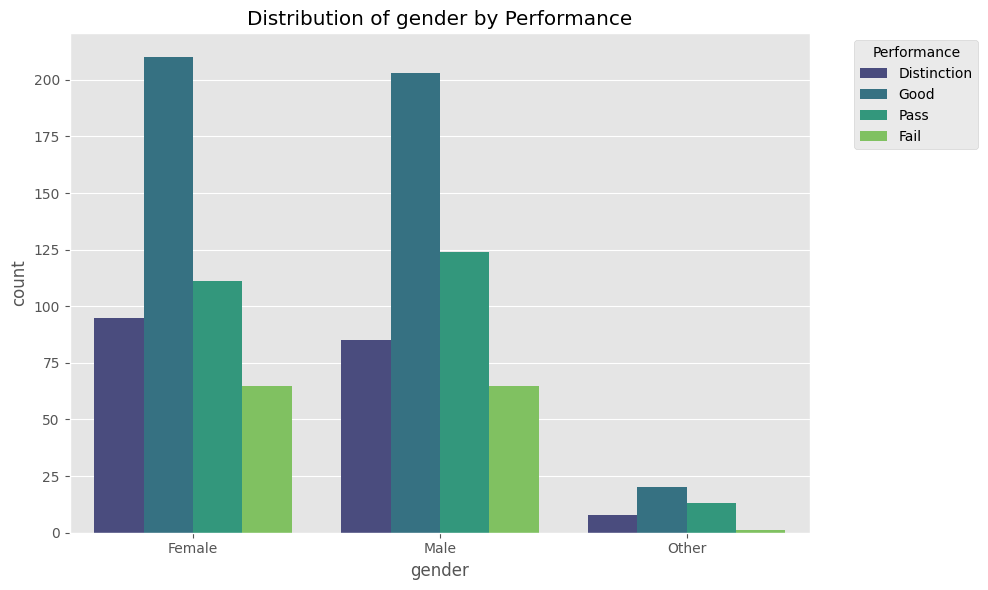

/tmp/ipython-input-583018749.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, order=category_order, palette='viridis')


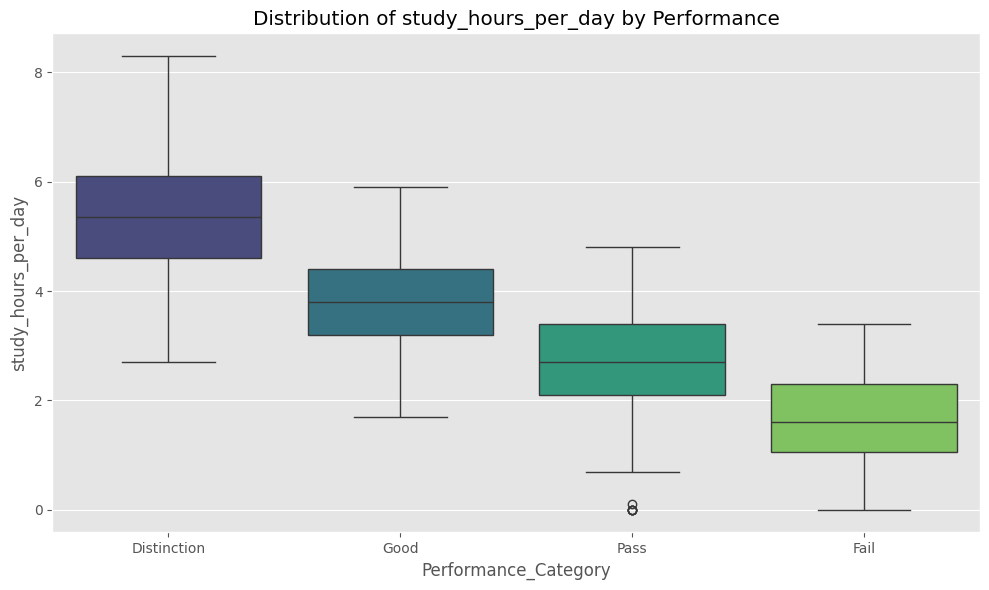

/tmp/ipython-input-583018749.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, order=category_order, palette='viridis')


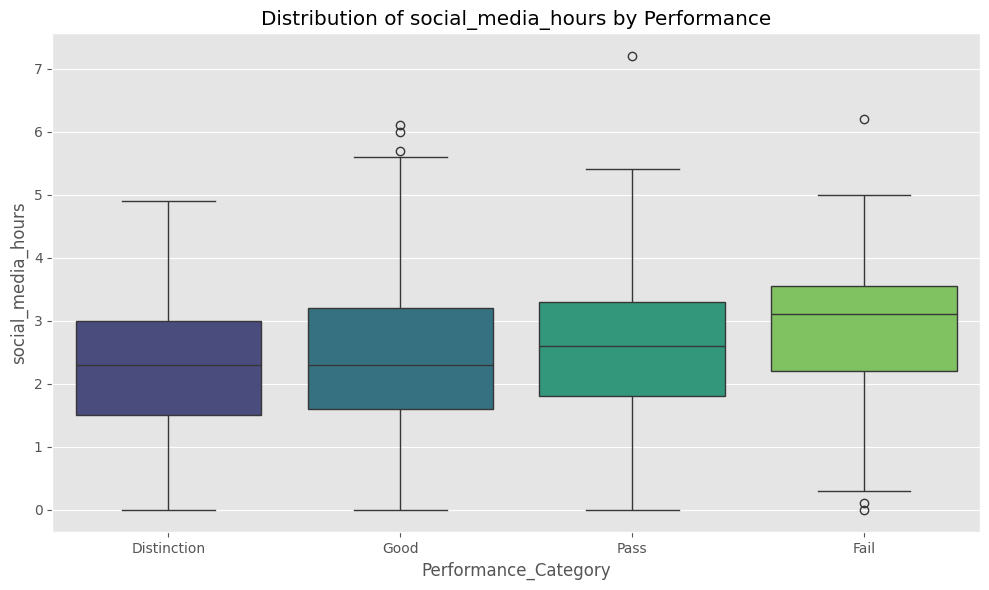

/tmp/ipython-input-583018749.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, order=category_order, palette='viridis')


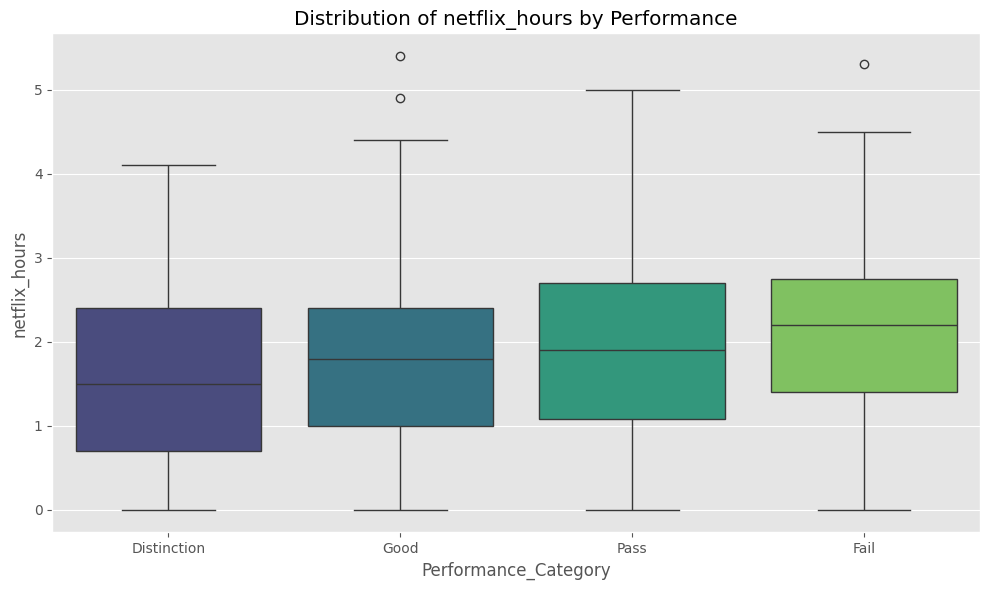

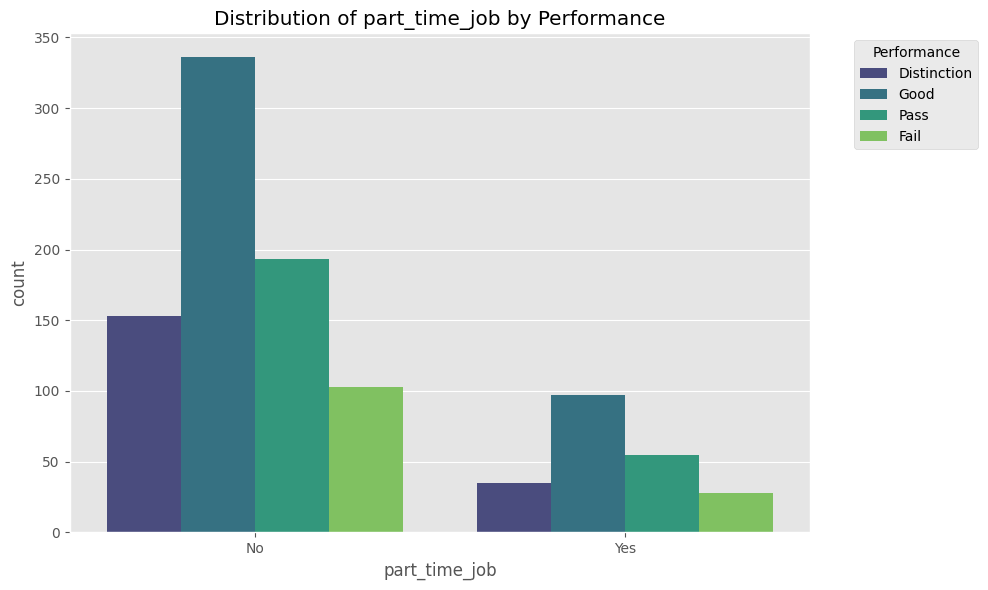

/tmp/ipython-input-583018749.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, order=category_order, palette='viridis')


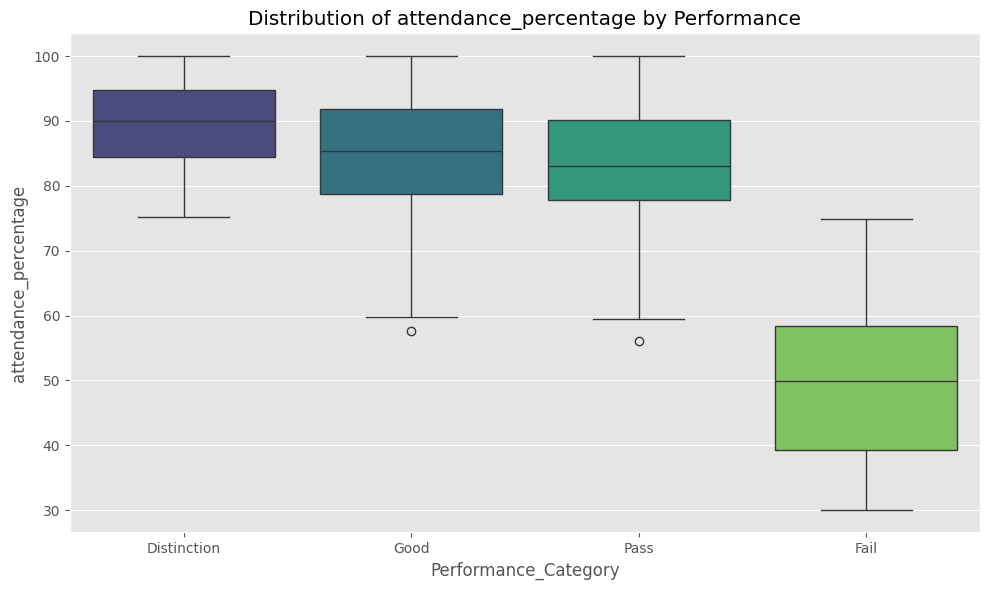

/tmp/ipython-input-583018749.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, order=category_order, palette='viridis')


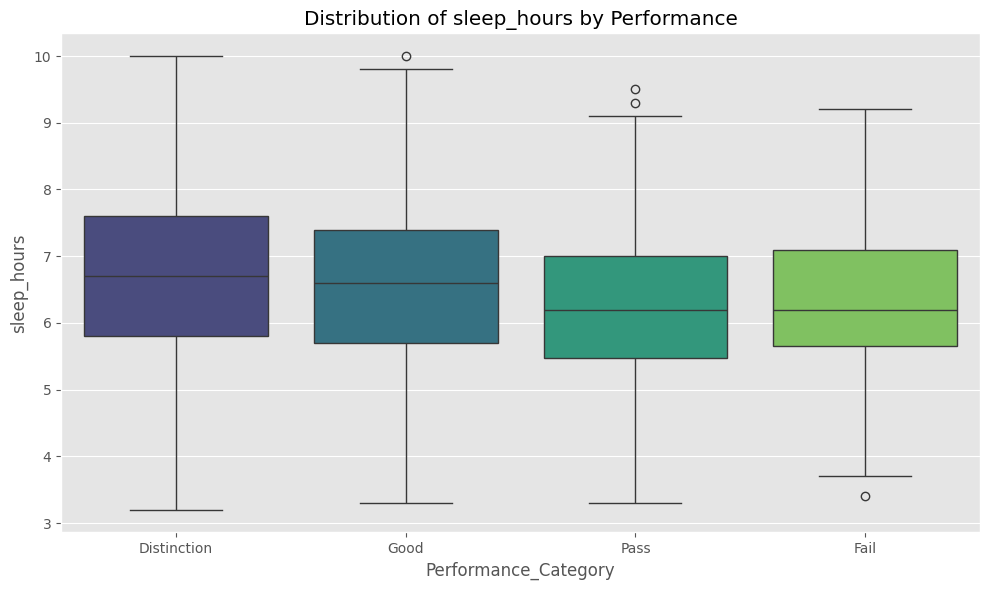

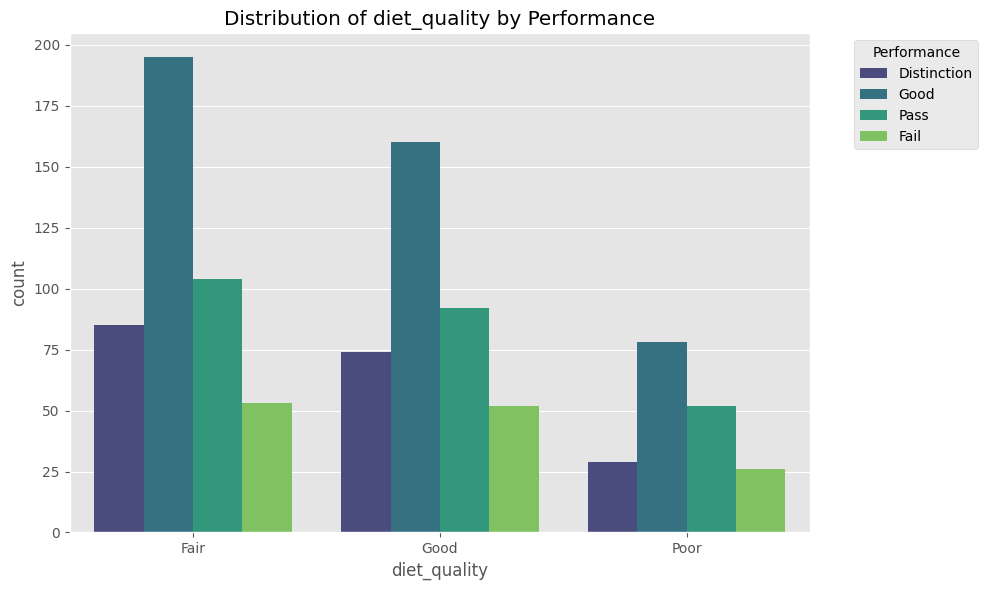

/tmp/ipython-input-583018749.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, order=category_order, palette='viridis')


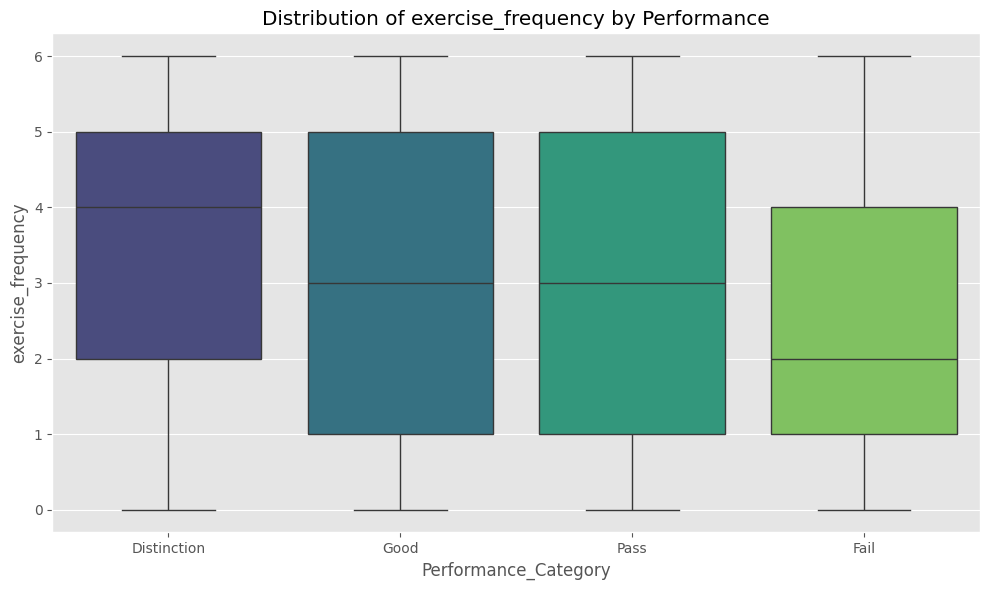

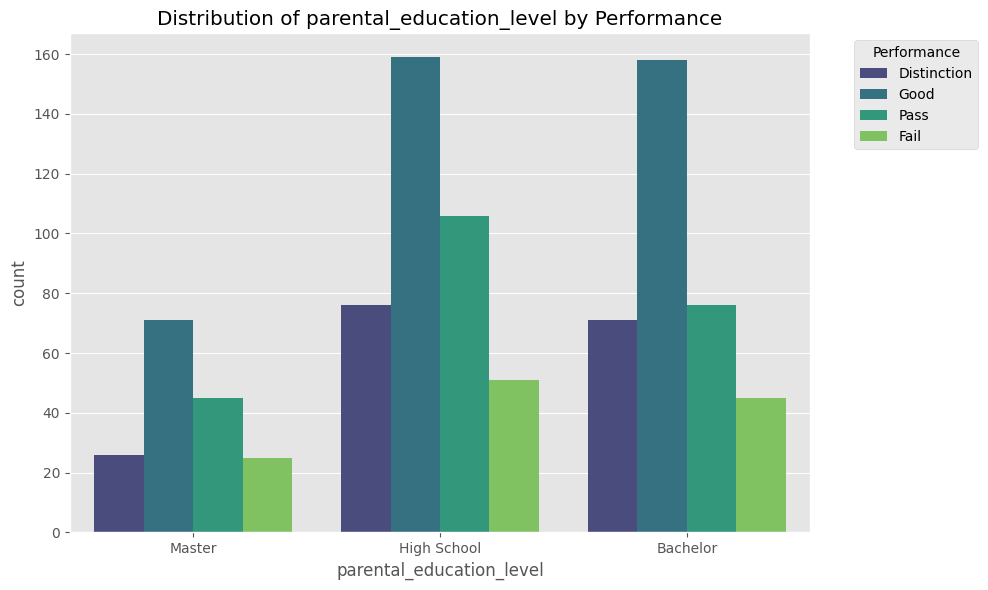

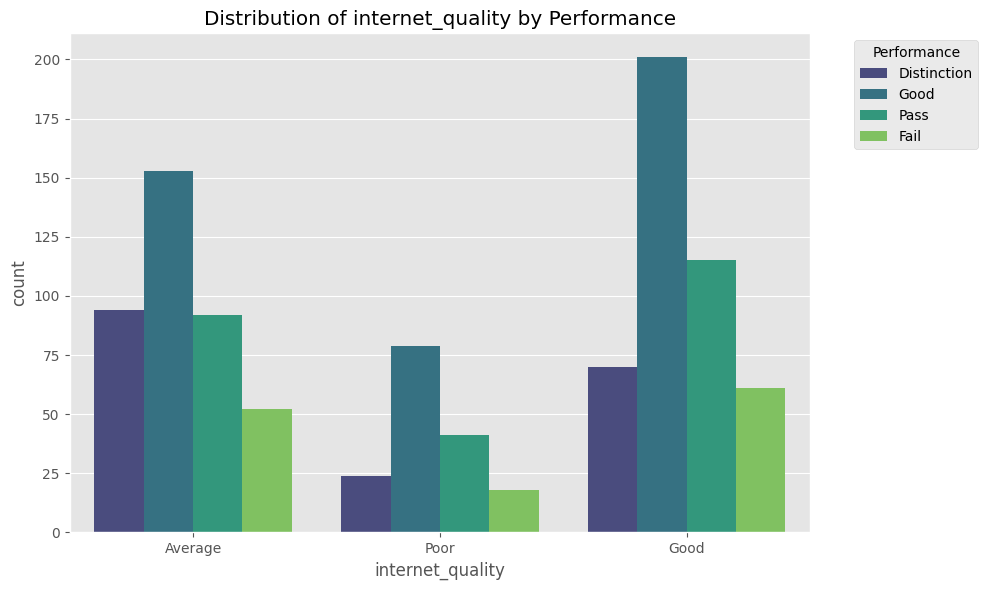

/tmp/ipython-input-583018749.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, order=category_order, palette='viridis')


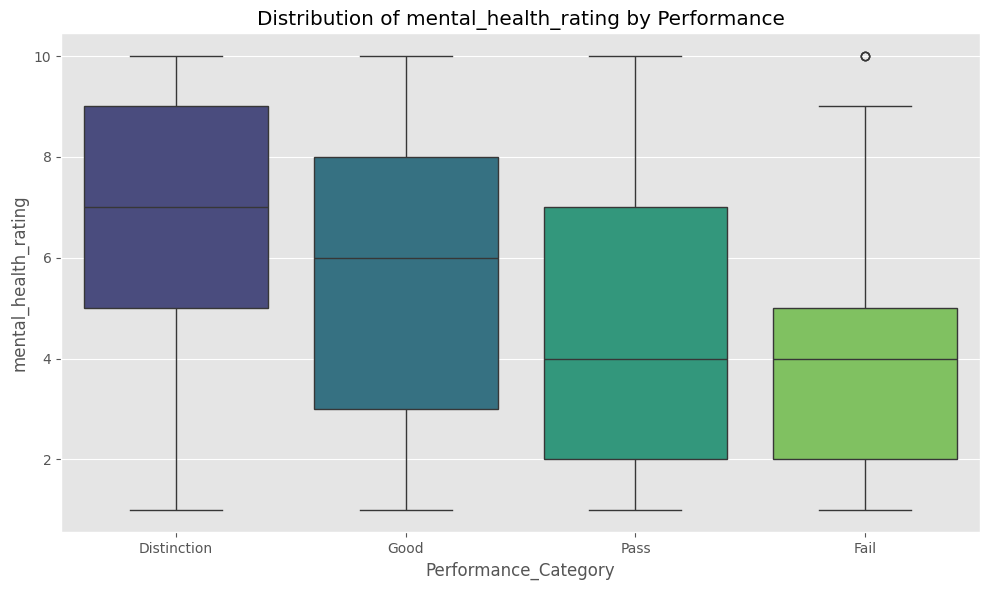

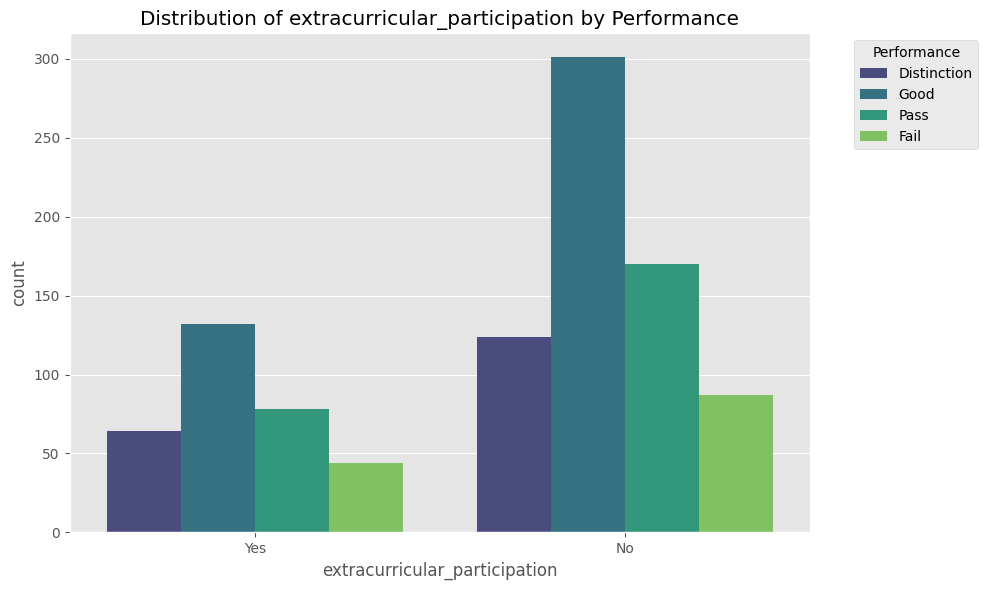

/tmp/ipython-input-583018749.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, order=category_order, palette='viridis')


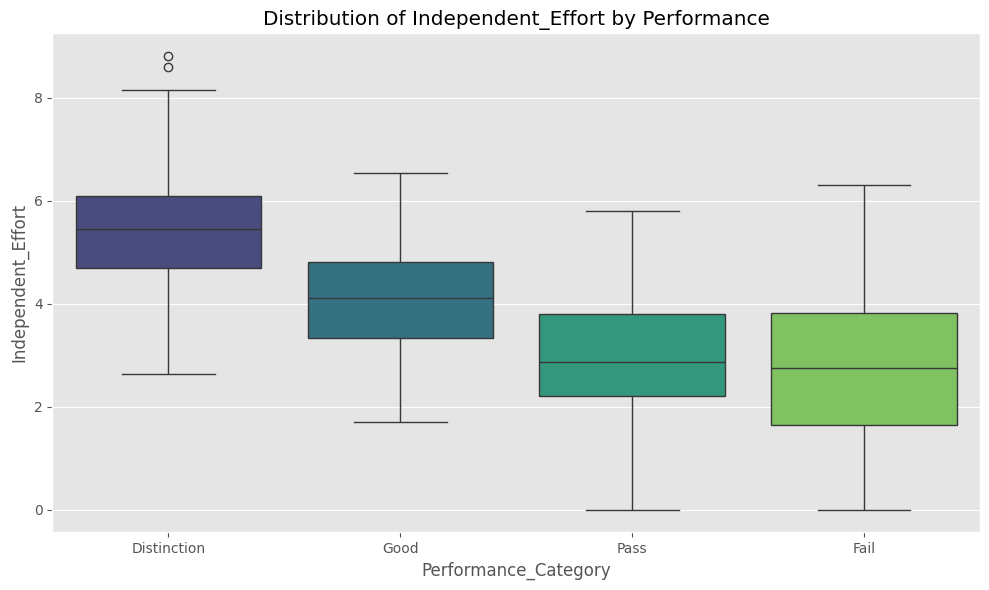

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def perform_comprehensive_eda(df, target_col='Performance_Category'):
    """
    Iterates through all columns in the dataframe and plots them against the target.
    - Numerical features: Boxplot
    - Categorical features: Countplot (Grouped Bar Chart)
    """
    # Define the order for the target categories to keep plots consistent
    category_order = ["Distinction", "Good", "Pass", "Fail"]

    # Separate features
    features = [col for col in df.columns if col != target_col]

    print(f"Generating plots for {len(features)} features...")

    for col in features:
        plt.figure(figsize=(10, 6))

        # Check data type
        if pd.api.types.is_numeric_dtype(df[col]):
            # Plot Numerical Feature vs Target
            sns.boxplot(x=target_col, y=col, data=df, order=category_order, palette='viridis')
            plt.title(f'Distribution of {col} by Performance')
        else:
            # Plot Categorical Feature vs Target
            sns.countplot(x=col, hue=target_col, data=df, hue_order=category_order, palette='viridis')
            plt.title(f'Distribution of {col} by Performance')
            plt.legend(title='Performance', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()


perform_comprehensive_eda(df)

## Feature Engineering

In [5]:
def feature_engineering(df):
    df = df.copy()

    # --- Derived Base Features ---
    if 'sleep_hours' in df.columns:
        df['sleep_deviation'] = df['sleep_hours'] - 8

    # --- Sleep Features ---
    df['is_severely_sleep_deprived'] = df['sleep_deviation'].apply(lambda x: 1 if x < -3.0 else 0)
    df['is_sleep_deficient'] = df['sleep_deviation'].apply(lambda x: 1 if x < -2.0 else 0)
    df['is_overslept'] = df['sleep_deviation'].apply(lambda x: 1 if x > 2.0 else 0)

    if 'social_media_hours' in df.columns and 'netflix_hours' in df.columns:
        df['total_distraction_hours'] = df['social_media_hours'] + df['netflix_hours']

    # --- Mental Health Features ---
    df['mental_health_risk_score'] = df['mental_health_rating'].apply(lambda x: 1 if x < 6 else 0)
    df['mental_health_ideal_score'] = df['mental_health_rating'].apply(lambda x: 1 if x >= 8 else 0)

    # --- Exercise Features ---
    df['is_sedentary'] = df['exercise_frequency'].apply(lambda x: 1 if x < 1 else 0)
    df['is_exercise_frequent'] = df['exercise_frequency'].apply(lambda x: 1 if x >= 4 else 0)

    return df

In [6]:
## Mapping
# Separate Features and Target
X = df.drop('Performance_Category', axis=1)
y = df['Performance_Category']

# Mapping Order
order = ['Fail', 'Pass', 'Good', 'Distinction']
mapping = {cls: i for i, cls in enumerate(order)}
print("Ordered Mapping Rules:", mapping)

# 3. Apply the mapping
y_encoded = y.map(mapping)
class_names = list(mapping.keys())

Ordered Mapping Rules: {'Fail': 0, 'Pass': 1, 'Good': 2, 'Distinction': 3}


In [7]:
## Splitting: 70% Train, 15% Validation, 15% Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.30, stratify=y_encoded, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED
)

print(f"Train Shape: {X_train.shape}, Val Shape: {X_val.shape}, Test Shape: {X_test.shape}")

Train Shape: (700, 15), Val Shape: (150, 15), Test Shape: (150, 15)


## Processing Pipeline

In [8]:
# Setup the Ordinal Hierarchies
part_time_job_order = ["No", "Yes"]
diet_quality_order = ["Poor", "Fair", "Good"]
parental_education_level_order = ["High School", "Bachelor", "Master"]
internet_quality_order = ["Poor", "Average", "Good"]
extracurricular_participation_order = ["No", "Yes"]

# Group the lists into one master list for the encoder.
ordinal_categories_list = [
    part_time_job_order,
    diet_quality_order,
    parental_education_level_order,
    internet_quality_order,
    extracurricular_participation_order
]

# Features for Label/Ordinal Encoding
ordinal_cols = [
    'part_time_job',
    'diet_quality',
    'parental_education_level',
    'internet_quality',
    'extracurricular_participation'
]

In [9]:
# Features for One-Hot Encoding
nominal_cols = ['gender']

# Numeric Features
numeric_features = ['age',
                    'study_hours_per_day',
                    'attendance_percentage',
                    'exercise_frequency',
                    'mental_health_rating',
                    'sleep_deviation',
                    'total_distraction_hours']

In [10]:
# Define Transformers

# A. Numeric Transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),          # Replace missing value with median
    ('scaler', StandardScaler())                            # scalling using standar scaller
])

# B. Ordinal Transformer (Label Encoding with specific order)
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),   # Replace missing value with mode
    ('ordinal', OrdinalEncoder(
        categories=ordinal_categories_list,
        handle_unknown='use_encoded_value',                 # Replace unknown values with -1 (test dataset to not leakage)
        unknown_value=-1
    ))
])

# C. Nominal Transformer (One-Hot for Gender)
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),   # Replace missing value with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [11]:
# To ensure there is no overlaps features
def select_numeric_cols(df):
    """
    Selects all numeric columns from the dataframe,
    BUT excludes any columns that are already in the ordinal/nominal lists.
    """
    # Get all numeric columns
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

    # Define what to exclude (the columns handled by other transformers)
    exclude_cols = ordinal_cols + nominal_cols

    # Return the difference
    return [c for c in numeric_cols if c not in exclude_cols]

In [12]:
# Combine into Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, select_numeric_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
    ],
    remainder='drop' # Drops any columns not specified above
)
# Create Feature Engineering Transformer
feature_eng_transformer = FunctionTransformer(feature_engineering, validate=False)

# Full Pipeline Construction (Preprocessing)
# Note: We apply feature engineering BEFORE column transformation to ensure new columns are processed
def get_pipeline(classifier, use_selection=False):
    steps = [
        ('feat_eng', feature_eng_transformer),
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42))
    ]

    if use_selection:
        # Uses a fast Random Forest to pick top features mostly compatible with trees
        selector = SelectFromModel(RandomForestClassifier(n_estimators=50, random_state=42))
        steps.append(('feature_selection', selector))

    steps.append(('classifier', classifier))
    return ImbPipeline(steps=steps)

## Hyperparameter Tuning

In [12]:
# To increase number of CPU core used for parallel processing, please adjust accordingly
# os.environ['LOKY_MAX_CPU_COUNT'] = '12'

In [18]:
def objective(trial):
    """
    Optimizes LightGBM, CatBoost, and XGBoost with broader hyperparameters
    to combat underfitting.
    """
    classifier_name = trial.suggest_categorical('classifier', ['LightGBM', 'CatBoost', 'XGBoost'])

    if classifier_name == 'LightGBM':
        param = {
            'n_estimators': trial.suggest_int('lgbm_n_estimators', 50, 400),
            'learning_rate': trial.suggest_float('lgbm_learning_rate', 0.01, 0.2),
            'num_leaves': trial.suggest_int('lgbm_num_leaves', 5, 20),
            'max_depth': trial.suggest_int('lgbm_max_depth', 2, 7),
            'min_child_samples': trial.suggest_int('lgbm_min_child_samples', 20, 100),

            'class_weight': 'balanced',
            'verbose': -1
        }
        clf = LGBMClassifier(**param, random_state=42, n_jobs=-1)

    elif classifier_name == 'CatBoost':
        param = {
            'iterations': trial.suggest_int('cat_iterations', 50, 400),
            'learning_rate': trial.suggest_float('cat_learning_rate', 0.01, 0.2),
            'depth': trial.suggest_int('cat_depth', 3, 6),
            'l2_leaf_reg': trial.suggest_float('cat_l2_leaf_reg', 3, 20), # Higher reg is safer
            'auto_class_weights': 'Balanced',
            'verbose': 0,
            'allow_writing_files': False
        }
        clf = CatBoostClassifier(**param, random_state=42, thread_count=-1)

    else: # XGBoost
        param = {
            'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 400),
            'max_depth': trial.suggest_int('xgb_max_depth', 2, 6),
            'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_float('xgb_subsample', 0.5, 0.9),
            'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.5, 0.9),
            'gamma': trial.suggest_float('xgb_gamma', 1, 10), # Increase Gamma to discourage splitting unless gain is high
            'eval_metric': 'mlogloss'
        }
        clf = XGBClassifier(**param, random_state=42, n_jobs=-1)

    # Build Pipeline using your existing get_pipeline function
    model = get_pipeline(clf, use_selection=False)

    # 3-Fold Stratified Cross-Validation
    # error_score='raise' helps debug if a specific model config crashes
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_weighted', error_score='raise')

    return scores.mean()

# Run Optimization
warnings.filterwarnings("ignore", category=UserWarning, message=".*X does not have valid feature names.*")
print("Starting Optuna Study with Advanced Models...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"Best Classifier: {study.best_params['classifier']}")
print(f"Best F1 Score: {study.best_value:.4f}")

[I 2025-12-14 12:30:55,163] A new study created in memory with name: no-name-e181a540-a7cc-4f5a-9b21-44944e9eb3e8


Starting Optuna Study with Advanced Models...


[I 2025-12-14 12:30:57,247] Trial 0 finished with value: 0.7593497937868043 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 202, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.09523483087656581, 'xgb_subsample': 0.822908990998054, 'xgb_colsample_bytree': 0.6945849830536588, 'xgb_gamma': 2.3160150674415907}. Best is trial 0 with value: 0.7593497937868043.
[I 2025-12-14 12:30:59,380] Trial 1 finished with value: 0.7602236128682102 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 349, 'xgb_max_depth': 2, 'xgb_learning_rate': 0.17413960816520707, 'xgb_subsample': 0.8223886903818554, 'xgb_colsample_bytree': 0.8240443147951656, 'xgb_gamma': 3.78067603909836}. Best is trial 1 with value: 0.7602236128682102.
[I 2025-12-14 12:31:07,339] Trial 2 finished with value: 0.7933687465673939 and parameters: {'classifier': 'CatBoost', 'cat_iterations': 382, 'cat_learning_rate': 0.11893004080762246, 'cat_depth': 5, 'cat_l2_leaf_reg': 5.856215548517465}. Best is trial 2 with value: 

Best Classifier: CatBoost
Best F1 Score: 0.8023


## Final evaluation & Feature Importance

In [19]:
# Extract Best Params & Instantiate Model
best_params = study.best_params.copy()
model_type = best_params.pop('classifier')

print(f"Training Final Model: {model_type}")

if model_type == 'LightGBM':
    # Clean keys (remove 'lgbm_' prefix)
    params = {k.replace('lgbm_', ''): v for k, v in best_params.items()}
    final_clf = LGBMClassifier(**params, random_state=42, n_jobs=-1)

elif model_type == 'CatBoost':
    # Clean keys (remove 'cat_' prefix)
    params = {k.replace('cat_', ''): v for k, v in best_params.items()}
    # CatBoost often needs specific handling for verbose
    final_clf = CatBoostClassifier(**params, random_state=42, thread_count=-1, verbose=0, allow_writing_files=False)

elif model_type == 'XGBoost':
    # Clean keys (remove 'xgb_' prefix)
    params = {k.replace('xgb_', ''): v for k, v in best_params.items()}
    final_clf = XGBClassifier(**params, random_state=42, n_jobs=-1)

# Build & Train Pipeline
final_pipeline = get_pipeline(final_clf, use_selection=False)
final_pipeline.fit(X_train, y_train)

Training Final Model: CatBoost


Pipeline(steps=[('feat_eng',
                 FunctionTransformer(func=<function feature_engineering at 0x7d5e192a7c40>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <function select_numeric_cols at 0x7d5d9f233060>),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy...
                                                  ['part_time_job',
                                                   'diet_quality',
                                                   'parental_education_level',
                                                   'internet_quality',
                                                   'extracurricular_participation']),
                                                 ('nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7d5d9029fda0>)])

In [25]:
# save the model
filename = f'final_model_{model_type}.pkl'
joblib.dump(final_pipeline, filename)

print(f"Model saved successfully to {filename}")

Model saved successfully to final_model_CatBoost.pkl



FINAL EVALUATION: CatBoost
Accuracy: 0.7800
F1 Score (Weighted): 0.7805

Classification Report:

              precision    recall  f1-score   support

        Fail       1.00      0.70      0.82        20
        Pass       0.77      0.73      0.75        37
        Good       0.76      0.83      0.79        65
 Distinction       0.73      0.79      0.76        28

    accuracy                           0.78       150
   macro avg       0.82      0.76      0.78       150
weighted avg       0.79      0.78      0.78       150



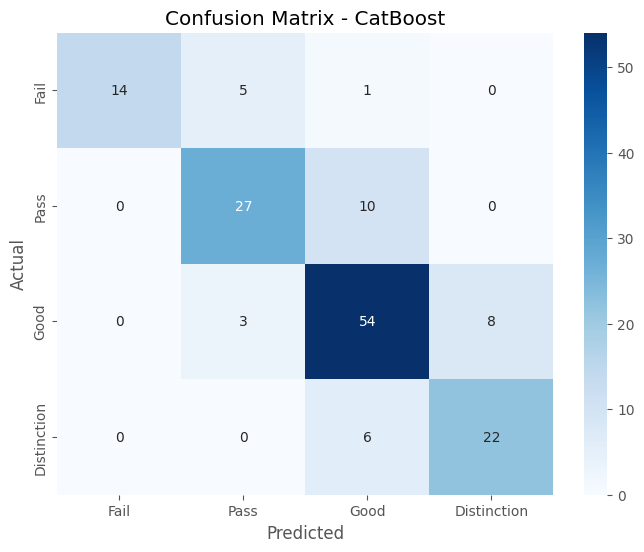

In [24]:
# Load the model
# final_pipeline = joblib.load(filename)

# Define labels
target_names = ['Fail', 'Pass', 'Good', 'Distinction']

# Make Predictions & Evaluate
y_pred = final_pipeline.predict(X_test)

print("\n" + "="*30)
print(f"FINAL EVALUATION: {model_type}")
print("="*30)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score (Weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title(f'Confusion Matrix - {model_type}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

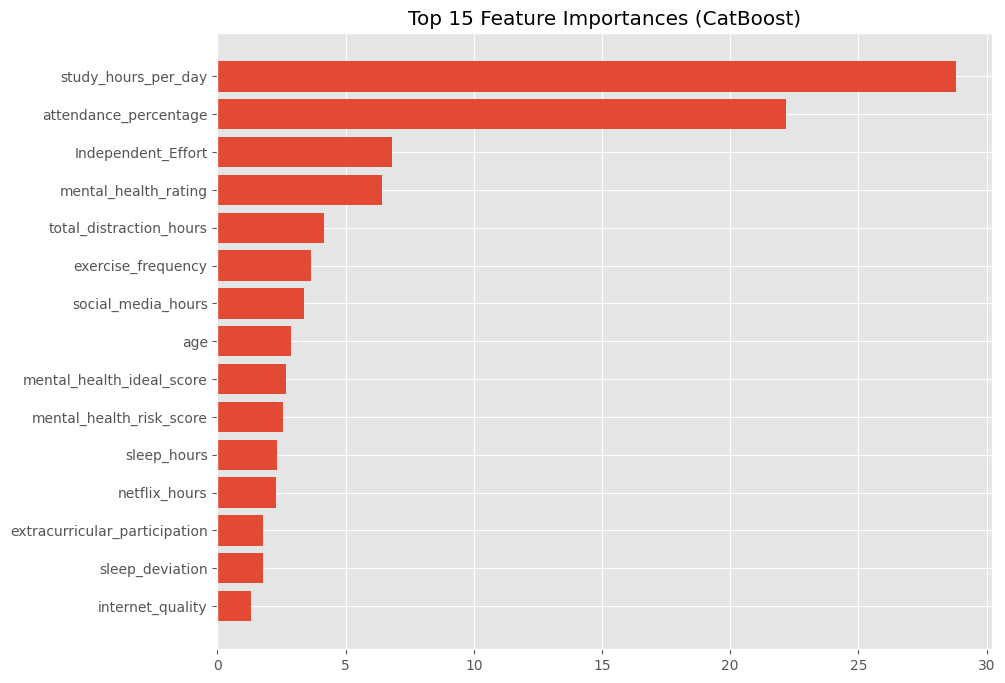

In [22]:
# Dynamic Feature Importance (will be revisited again)
def get_feature_names(pipeline):
    """
    Extracts feature names from a pipeline with heterogeneous sources.
    """
    try:
        # Access the preprocessor (ColTrans) inside the pipeline
        preprocessor = pipeline.named_steps['preprocessor']

        output_features = []

        # Loop through transformers in the ColumnTransformer
        for name, transformer, cols in preprocessor.transformers_:
            if name == 'remainder' and transformer == 'drop':
                continue # Skip dropped columns

            if hasattr(transformer, 'get_feature_names_out'):
                names = transformer.get_feature_names_out(cols)
                output_features.extend(names)
            elif name == 'num':
                 # Fallback for Numeric pipeline if get_feature_names_out fails
                 if hasattr(transformer, 'get_feature_names_out'):
                      output_features.extend(transformer.get_feature_names_out())
                 else:
                      output_features.extend([f"num_{i}" for i in range(transformer.n_features_in_)])
            else:
                output_features.extend(cols)

        return output_features
    except Exception as e:
        print(f"Could not extract feature names: {e}")
        return []

# Attempt to plot importance
if hasattr(final_clf, 'feature_importances_'):
    try:
        # Get importances
        importances = final_clf.feature_importances_

        # Get names (This is best effort due to dynamic pipelines)
        feature_names = get_feature_names(final_pipeline)

        # Safety check for length mismatch
        if len(feature_names) != len(importances):
            print(f"Warning: Name length ({len(feature_names)}) != Importance length ({len(importances)})")
            feature_names = [f"Feature {i}" for i in range(len(importances))]

        # Plot Top 15
        indices = np.argsort(importances)[::-1][:15]
        plt.figure(figsize=(10, 8))
        plt.title(f"Top 15 Feature Importances ({model_type})")
        plt.barh(range(len(indices)), importances[indices], align="center")
        plt.yticks(range(len(indices)), np.array(feature_names)[indices])
        plt.gca().invert_yaxis()
        plt.show()

    except Exception as e:
        print(f"Feature importance plotting failed: {e}")

## For comparison (feature selection = True) XGBOOST somehow win this. Report team, please research why xgboost win over catboost when feature selection is true. (So we can make justification)


FINAL EVALUATION: XGBoost
Accuracy: 0.7800
F1 Score (Weighted): 0.7813

Classification Report:

              precision    recall  f1-score   support

        Fail       0.94      0.80      0.86        20
        Pass       0.77      0.81      0.79        37
        Good       0.80      0.74      0.77        65
 Distinction       0.68      0.82      0.74        28

    accuracy                           0.78       150
   macro avg       0.80      0.79      0.79       150
weighted avg       0.79      0.78      0.78       150



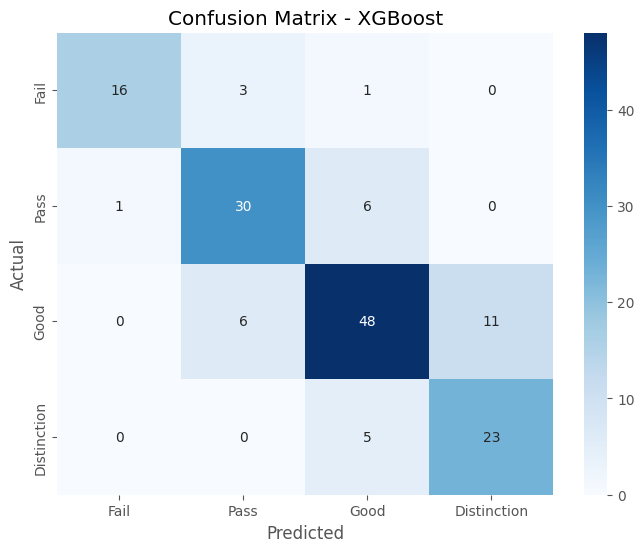

In [16]:
# # Load the model
# # final_pipeline = joblib.load(filename)

# # Define labels
# target_names = ['Fail', 'Pass', 'Good', 'Distinction']

# # Make Predictions & Evaluate
# y_pred = final_pipeline.predict(X_test)

# print("\n" + "="*30)
# print(f"FINAL EVALUATION: {model_type}")
# print("="*30)
# print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
# print(f"F1 Score (Weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
# print("\nClassification Report:\n")
# print(classification_report(y_test, y_pred, target_names=target_names))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=target_names,
#             yticklabels=target_names)
# plt.title(f'Confusion Matrix - {model_type}')
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()

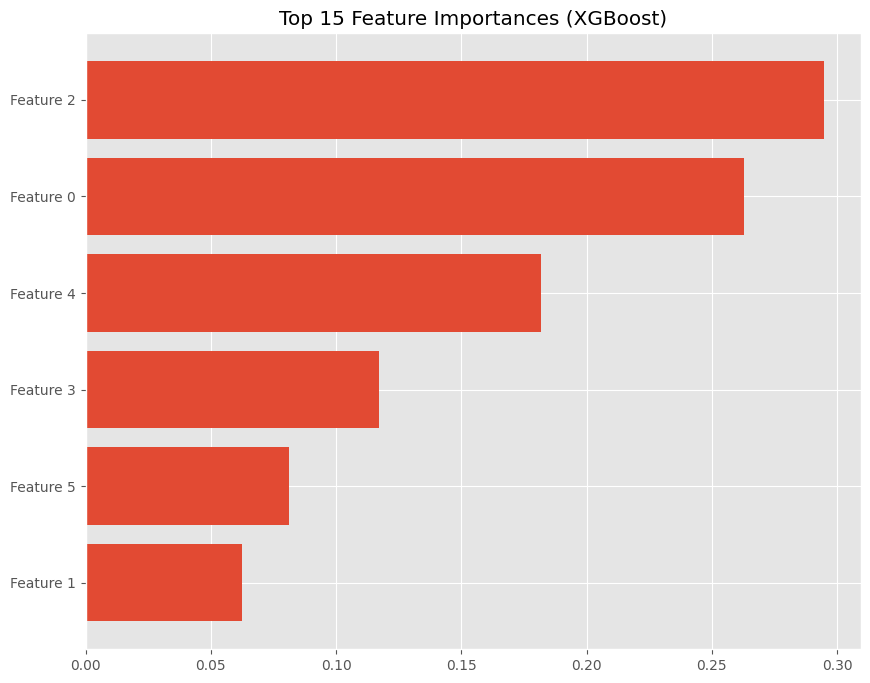

In [17]:
# # Dynamic Feature Importance (will be revisited again)
# def get_feature_names(pipeline):
#     """
#     Extracts feature names from a pipeline with heterogeneous sources.
#     """
#     try:
#         # Access the preprocessor (ColTrans) inside the pipeline
#         preprocessor = pipeline.named_steps['preprocessor']

#         output_features = []

#         # Loop through transformers in the ColumnTransformer
#         for name, transformer, cols in preprocessor.transformers_:
#             if name == 'remainder' and transformer == 'drop':
#                 continue # Skip dropped columns

#             if hasattr(transformer, 'get_feature_names_out'):
#                 names = transformer.get_feature_names_out(cols)
#                 output_features.extend(names)
#             elif name == 'num':
#                  # Fallback for Numeric pipeline if get_feature_names_out fails
#                  if hasattr(transformer, 'get_feature_names_out'):
#                       output_features.extend(transformer.get_feature_names_out())
#                  else:
#                       output_features.extend([f"num_{i}" for i in range(transformer.n_features_in_)])
#             else:
#                 output_features.extend(cols)

#         return output_features
#     except Exception as e:
#         print(f"Could not extract feature names: {e}")
#         return []

# # Attempt to plot importance
# if hasattr(final_clf, 'feature_importances_'):
#     try:
#         # Get importances
#         importances = final_clf.feature_importances_

#         # Get names (This is best effort due to dynamic pipelines)
#         feature_names = get_feature_names(final_pipeline)

#         # Safety check for length mismatch
#         if len(feature_names) != len(importances):
#             print(f"Warning: Name length ({len(feature_names)}) != Importance length ({len(importances)})")
#             feature_names = [f"Feature {i}" for i in range(len(importances))]

#         # Plot Top 15
#         indices = np.argsort(importances)[::-1][:15]
#         plt.figure(figsize=(10, 8))
#         plt.title(f"Top 15 Feature Importances ({model_type})")
#         plt.barh(range(len(indices)), importances[indices], align="center")
#         plt.yticks(range(len(indices)), np.array(feature_names)[indices])
#         plt.gca().invert_yaxis()
#         plt.show()

#     except Exception as e:
#         print(f"Feature importance plotting failed: {e}")